# Client order 8 :: *ipynb solution draft* <br>

## Client Order #8

شرکت از شما می‌خواهد تا بررسی کنید چند نوع متفاوت لپ‌تاپ در بازار حال حاضر ایران وجود دارد (لپ‌تاپ‌های با ویژگی‌ها شبیه به هم در یک دسته قرار می‌گیرند) و وجه تشابه لپ‌تاپ‌های هم نوع چه چیز‌هایی می‌باشد. بعد از آن بررسی کنید در گذشته میزان فروش شرکت نسبت به انواع مختلف به چه شکلی می‌باشد.

---

## Read Data

In [43]:
# Import libraries

import order_functions as orf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn. tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, confusion_matrix

In [44]:
# Read data / Clean version of sales_data.csv

df = pd.read_csv("laptop_data.csv")

In [45]:
df.head()

,Unnamed: 0,Device Type,Weight,Screen Size,Screen Type,Screen Resolution,Processor Manufacturer,Processor Series,Processor Model,Processor Cache Memory,...,Battery Life,Operating System,RAM Frequency,Battery Cell Count,manufacturer,Model,org_price,Discount Percent,store,exist
0,0,نوت بوک (لپ تاپ),1.900,15.0,PixelSense™ Display,2160 * 3840,INTEL,Core i7,8650U,8.0,...,17.0,Microsoft Windows 10,NaN,NaN,microsoft,surface-book-2,66800000.0,1.5,meghdad,exist
1,1,نوت بوک (لپ تاپ),1.530,13.5,PixelSense™ Display,2000 * 3000,INTEL,Core i7,8650U,8.0,...,17.0,Microsoft Windows 10,NaN,NaN,microsoft,surface-book-2,55812000.0,0.7,meghdad,exist
2,2,نوت بوک (لپ تاپ),1.200,13.5,PixelSense™ Display,2256 * 1504,INTEL,Core i5,1035G7,6.0,...,14.0,Microsoft Windows 10,NaN,NaN,microsoft,surface-laptop-3-b,40000000.0,2.4,meghdad,exist
3,3,نوت بوک (لپ تاپ),1.534,13.5,PixelSense™ Display,2000 * 3000,INTEL,Core i7,1065 G7,8.0,...,15.0,Microsoft Windows 10,NaN,NaN,microsoft,surface-book-3,60500000.0,1.6,meghdad,exist
4,4,نوت بوک (لپ تاپ),1.200,13.5,PixelSense™ Display,2256 * 1504,INTEL,Core i5,1035G7,6.0,...,14.0,Microsoft Windows 10,NaN,NaN,microsoft,surface-laptop-3-a,36288000.0,2.7,meghdad,exist


In [46]:
# BASE :: Laptop details from competitor and market data

df_base = orf.preprocess_market_data(df)

In [47]:
# DEPOT :: Sales data of our own market

df_depot = pd.read_csv("sales_data_clean.csv")
df_depot = orf.convert_shamsi_to_datetime(df_depot, "Order_Date")

df_depot["Screen_resolution_width"] = (
    df_depot["Screen_resolution"].str.split("x").str[0].astype(int)
)
df_depot["Screen_resolution_height"] = (
    df_depot["Screen_resolution"].str.split("x").str[1].astype(int)
)
df_depot.drop("Screen_resolution", axis=1, inplace=True)

df_depot = df_depot[df_base.columns].copy()

## Aligning Base & Depot dataframes

In [48]:
# 1. CPU_Brand :: Intel, AMD & ETC
# Replace all CPU brands in base and depot which are not Intel or AMD, with ETC


def refine_cpu_brand(brand_name):
    if brand_name in ["Intel", "AMD"]:
        return brand_name
    else:
        return "ETC"


df_base["CPU_Brand"] = df_base["CPU_Brand"].apply(refine_cpu_brand)
df_depot["CPU_Brand"] = df_depot["CPU_Brand"].apply(refine_cpu_brand)

In [49]:
# 2. GPU_Brand :: Nvidia, AMD, Intel & ETC
# Replace all GPU brands in base and depot which are not Nvidia, AMD or Intel, with ETC


def refine_gpu_brand(brand_name):
    if brand_name in ["Nvidia", "AMD", "Intel"]:
        return brand_name
    else:
        return "ETC"


df_base["GPU_Brand"] = df_base["GPU_Brand"].apply(refine_gpu_brand)
df_depot["GPU_Brand"] = df_depot["GPU_Brand"].apply(refine_gpu_brand)

In [50]:
# 3. OS :: Windows, MacOS, Linux & ETC
# Replace all OS in base and depot which are not Windows, MacOS or Linux, with ETC


def refine_os(os_name):
    if os_name in ["Windows", "Linux"]:
        return os_name
    else:
        return "ETC"


df_base["OS"] = df_base["OS"].apply(refine_os)
df_depot["OS"] = df_depot["OS"].apply(refine_os)

In [51]:
# 4. Manufacturer :: Use only the most frequent manufacturers
# Replace all manufacturers in base and depot which are not in the manofacturer_unique list, with ETC
manufacturer_unique = set(df_base["Manufacturer"].unique()).intersection(
    set(df_depot["Manufacturer"].unique())
)


def refine_manufacturer(manufacturer_name):
    if manufacturer_name in manufacturer_unique:
        return manufacturer_name
    else:
        return "ETC"


df_base["Manufacturer"] = df_base["Manufacturer"].apply(refine_manufacturer)
df_depot["Manufacturer"] = df_depot["Manufacturer"].apply(refine_manufacturer)

In [52]:
# 5. Category :: remove netbook from df_depot
# Remove rows with Category == "Netbook" from df_depot

df_depot = df_depot[df_depot["Category"] != "Netbook"]

In [53]:
df_base.head()

,Weight,Screen_Size,CPU_Brand,CPU_GHZ,RAM,GPU_Brand,GPU_Model,OS,Manufacturer,Price,Category,Screen_resolution_width,Screen_resolution_height,CPU_Model,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total
0,1.900,15.0,Intel,1.9,16,Nvidia,GTX 1060 GDDR5,Windows,Microsoft,66800000.0,2 in 1 Convertible,2160,3840,Core i7 8650U,512,0,0,0,512
1,1.530,13.5,Intel,1.9,16,Nvidia,GeForce® GTX 1050 GDDR5,Windows,Microsoft,55812000.0,2 in 1 Convertible,2000,3000,Core i7 8650U,512,0,0,0,512
2,1.200,13.5,Intel,1.2,8,Intel,Intel Iris Plus Graphics,Windows,Microsoft,40000000.0,2 in 1 Convertible,2256,1504,Core i5 1035G7,256,0,0,0,256
3,1.534,13.5,Intel,0.0,16,Nvidia,GTX 1650 with Max-Q Design,Windows,Microsoft,60500000.0,2 in 1 Convertible,2000,3000,Core i7 1065 G7,256,0,0,0,256
4,1.200,13.5,Intel,1.2,8,Intel,Intel Iris Plus Graphics,Windows,Microsoft,36288000.0,2 in 1 Convertible,2256,1504,Core i5 1035G7,128,0,0,0,128


In [54]:
df_depot.head()

,Weight,Screen_Size,CPU_Brand,CPU_GHZ,RAM,GPU_Brand,GPU_Model,OS,Manufacturer,Price,Category,Screen_resolution_width,Screen_resolution_height,CPU_Model,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total
0,2.18,15.6,Intel,2.5,8,AMD,Radeon R5 M420,Windows,Dell,3450000,Notebook,1920,1080,Core i5 7200U,256,0,0,0,256
1,1.30,13.3,Intel,2.5,8,Intel,HD Graphics 620,Windows,Lenovo,3400000,2 in 1 Convertible,1920,1080,Core i5 7200U,256,0,0,0,256
2,2.60,15.6,Intel,2.6,8,Nvidia,GeForce GTX 960M,Windows,Lenovo,44900000,Notebook,1920,1080,Core i7 6700HQ,0,1024,0,0,1024
3,1.40,13.3,Intel,1.8,8,AMD,Radeon 530,Windows,Dell,12550000,Ultrabook,1920,1080,Core i7 8550U,256,0,0,0,256
4,2.23,15.6,Intel,2.5,4,Nvidia,GeForce 940MX,Windows,Acer,2050000,Notebook,1920,1080,Core i5 7200U,256,0,0,0,256


In [55]:
# Filter columns needed for analysis and create a new dataframe

cols_for_analyze_8 = [
    "Weight",
    "Screen_Size",
    "Screen_resolution_width",
    "Screen_resolution_height",
    "CPU_Brand",
    "CPU_GHZ",  #'CPU_Model',
    "RAM",
    "GPU_Brand",  #'GPU_Model',
    "OS",
    "Manufacturer",
    "Price",
    "Category",
    "Storage_SSD",
    "Storage_HDD",
    "Storage_Hybrid",
    "Storage_Flash",  # 'Storage_Total'
]

df_base = df_base[cols_for_analyze_8]
df_depot = df_depot[cols_for_analyze_8]

In [56]:
categorical_columns = ["CPU_Brand", "GPU_Brand", "OS", "Manufacturer", "Category"]

le_cpu = LabelEncoder()
le_gpu = LabelEncoder()
le_os = LabelEncoder()
le_manufacturer = LabelEncoder()
le_category = LabelEncoder()

df_base["CPU_Brand"] = le_cpu.fit_transform(df_base["CPU_Brand"])
df_depot["CPU_Brand"] = le_cpu.transform(df_depot["CPU_Brand"])

df_base["GPU_Brand"] = le_gpu.fit_transform(df_base["GPU_Brand"])
df_depot["GPU_Brand"] = le_gpu.transform(df_depot["GPU_Brand"])

df_base["OS"] = le_os.fit_transform(df_base["OS"])
df_depot["OS"] = le_os.transform(df_depot["OS"])

df_base["Manufacturer"] = le_manufacturer.fit_transform(df_base["Manufacturer"])
df_depot["Manufacturer"] = le_manufacturer.transform(df_depot["Manufacturer"])

df_base["Category"] = le_category.fit_transform(df_base["Category"])
df_depot["Category"] = le_category.transform(df_depot["Category"])

In [57]:
cpu_classes = dict(zip(le_cpu.classes_, le_cpu.transform(le_cpu.classes_)))
print(f"CPU Classes: {cpu_classes}")
gpu_classes = dict(zip(le_gpu.classes_, le_gpu.transform(le_gpu.classes_)))
print(f"GPU Classes: {gpu_classes}")
os_classes = dict(zip(le_os.classes_, le_os.transform(le_os.classes_)))
print(f"OS Classes: {os_classes}")
manufacturer_classes = dict(
    zip(le_manufacturer.classes_, le_manufacturer.transform(le_manufacturer.classes_))
)
print(f"Manufacturer Classes: {manufacturer_classes}")
category_classes = dict(
    zip(le_category.classes_, le_category.transform(le_category.classes_))
)
print(f"Category Classes: {category_classes}")

CPU Classes: {'AMD': 0, 'ETC': 1, 'Intel': 2}
GPU Classes: {'AMD': 0, 'ETC': 1, 'Intel': 2, 'Nvidia': 3}
OS Classes: {'ETC': 0, 'Linux': 1, 'Windows': 2}
Manufacturer Classes: {'Acer': 0, 'Apple': 1, 'Asus': 2, 'Dell': 3, 'ETC': 4, 'Fujitsu': 5, 'HP': 6, 'Huawei': 7, 'LG': 8, 'Lenovo': 9, 'MSI': 10, 'Microsoft': 11, 'Razer': 12, 'Samsung': 13, 'Toshiba': 14, 'Xiaomi': 15}
Category Classes: {'2 in 1 Convertible': 0, 'Gaming': 1, 'Notebook': 2, 'Ultrabook': 3, 'Workstation': 4}


In [58]:
df_base.head()

,Weight,Screen_Size,Screen_resolution_width,Screen_resolution_height,CPU_Brand,CPU_GHZ,RAM,GPU_Brand,OS,Manufacturer,Price,Category,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash
0,1.900,15.0,2160,3840,2,1.9,16,3,2,11,66800000.0,0,512,0,0,0
1,1.530,13.5,2000,3000,2,1.9,16,3,2,11,55812000.0,0,512,0,0,0
2,1.200,13.5,2256,1504,2,1.2,8,2,2,11,40000000.0,0,256,0,0,0
3,1.534,13.5,2000,3000,2,0.0,16,3,2,11,60500000.0,0,256,0,0,0
4,1.200,13.5,2256,1504,2,1.2,8,2,2,11,36288000.0,0,128,0,0,0


In [59]:
df_depot.head()

,Weight,Screen_Size,Screen_resolution_width,Screen_resolution_height,CPU_Brand,CPU_GHZ,RAM,GPU_Brand,OS,Manufacturer,Price,Category,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash
0,2.18,15.6,1920,1080,2,2.5,8,0,2,3,3450000,2,256,0,0,0
1,1.30,13.3,1920,1080,2,2.5,8,2,2,9,3400000,0,256,0,0,0
2,2.60,15.6,1920,1080,2,2.6,8,3,2,9,44900000,2,0,1024,0,0
3,1.40,13.3,1920,1080,2,1.8,8,0,2,3,12550000,3,256,0,0,0
4,2.23,15.6,1920,1080,2,2.5,4,3,2,0,2050000,2,256,0,0,0


In [60]:
print(f'Maximum Screen Size: {df_base["Screen_Size"].max()}')
print(f'Minimum Screen Size: {df_base["Screen_Size"].min()}')

Maximum Screen Size: 18.4
Minimum Screen Size: 0.0


In [61]:
df_base = pd.get_dummies(df_base, columns=categorical_columns)
df_depot = pd.get_dummies(df_depot, columns=categorical_columns)

scaler = MinMaxScaler()
df_base = pd.DataFrame(scaler.fit_transform(df_base), columns=df_base.columns)
df_depot = pd.DataFrame(scaler.transform(df_depot), columns=df_depot.columns)

## Clustering

> We will use **DBCAN** *(Density-Based Spatial Clustering of Applications with Noise)* to define clusters. <br><br>
> It requires two parameters:   <br>
> - **eps**: The maximum distance between two samples for one to be considered as in the neighborhood of the other. <br>
> - **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.  <br><br>
The challenge here is to choose the right values for eps and min_samples.   <br>
A common technique to find an appropriate value for eps is to use the **k-distance plot**.  <br>
We'll first plot this to determine the value of eps and then fine-tune min_samples accordingly.​​   <br>

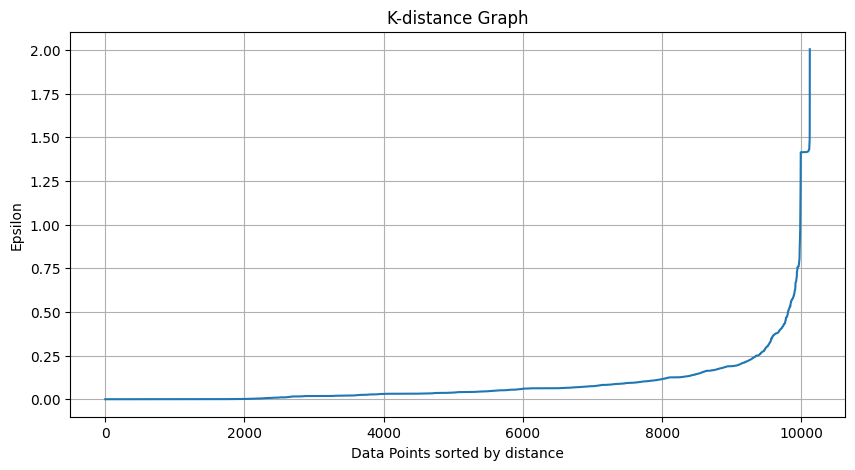

In [62]:
# Use K-Distance Plot to determine the optimum value of Epsilon

nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(df_base)
distances, indices = neighbors.kneighbors(df_base)

# Sort distance values
distances = np.sort(distances[:, 4], axis=0)

# Plotting the k-distance plot
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("Epsilon")
plt.grid()
plt.show()

> It appears that the point of maximum curve (elbow) to be somewhere around 0.2 to 0.25   <br>
> We will go with eps = 0.21

In [63]:
estimated_eps = 0.25
min_samples_value = df_base.shape[1] + 1

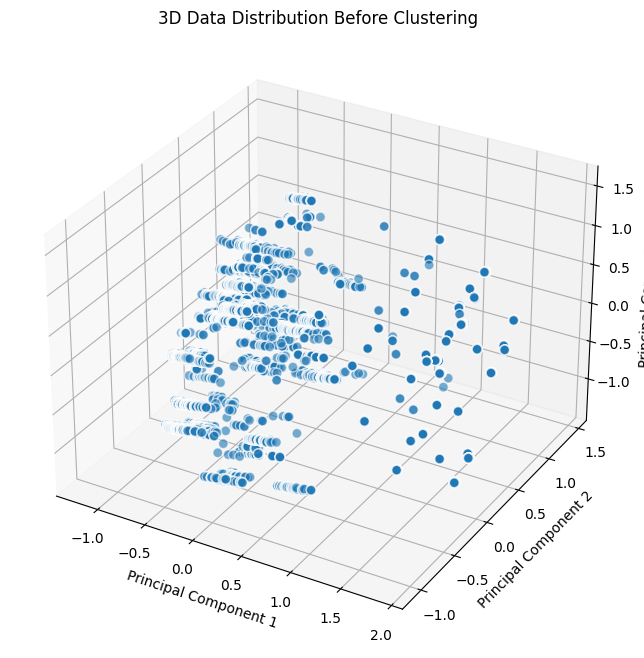

In [64]:
pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df_base)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df_pca_3d[:, 0], df_pca_3d[:, 1], df_pca_3d[:, 2], alpha=0.6, edgecolor="w", s=50
)
ax.set_title("3D Data Distribution Before Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()

In [65]:
dbscan_pca_3d = DBSCAN(eps=estimated_eps, min_samples=min_samples_value)
clusters_pca_3d = dbscan_pca_3d.fit_predict(df_pca_3d)

n_clusters_pca_3d = len(set(clusters_pca_3d)) - (1 if -1 in clusters_pca_3d else 0)
n_noise_pca_3d = list(clusters_pca_3d).count(-1)

n_clusters_pca_3d, n_noise_pca_3d

(23, 413)

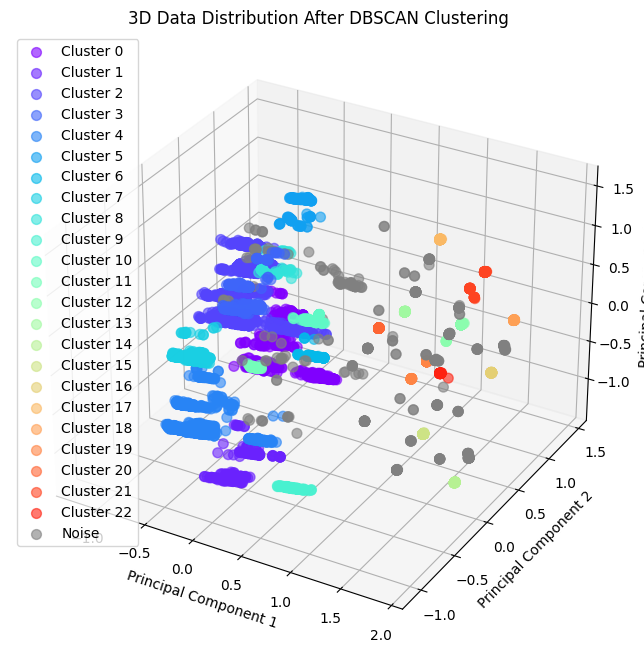

In [66]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters_pca_3d))))
for cluster, color in zip(set(clusters_pca_3d), colors):
    mask = clusters_pca_3d == cluster
    if cluster == -1:  # Noise
        label = "Noise"
        ax.scatter(
            df_pca_3d[mask, 0],
            df_pca_3d[mask, 1],
            df_pca_3d[mask, 2],
            color="gray",
            label=label,
            alpha=0.6,
            s=50,
        )
    else:
        label = f"Cluster {cluster}"
        ax.scatter(
            df_pca_3d[mask, 0],
            df_pca_3d[mask, 1],
            df_pca_3d[mask, 2],
            color=color,
            label=label,
            alpha=0.6,
            s=50,
        )

ax.set_title("3D Data Distribution After DBSCAN Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
plt.show()

In [67]:
df_3d = df_base.copy()
df_3d["Cluster_3D"] = clusters_pca_3d

cluster_means_pca_3d = df_3d.groupby("Cluster_3D").mean()

cluster_means_pca_3d.transpose()

Cluster_3D,-1,0,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,21,22
Weight,0.089905,0.413295,0.252499,0.378516,0.348504,0.307054,0.407405,0.284246,0.376892,0.362514,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Screen_Size,0.215391,0.847270,0.753827,0.846483,0.836472,0.807755,0.855094,0.773455,0.832729,0.845947,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Screen_resolution_width,0.080357,0.354636,0.344016,0.305903,0.260595,0.283020,0.331883,0.633833,0.272040,0.310885,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Screen_resolution_height,0.118271,0.525433,0.411119,0.458161,0.390002,0.419469,0.493532,0.586858,0.403790,0.463667,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CPU_GHZ,0.088501,0.416297,0.333694,0.362366,0.333898,0.323790,0.472338,0.124060,0.398663,0.446712,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RAM,0.111418,0.160654,0.079959,0.114564,0.062562,0.061350,0.162651,0.125000,0.065241,0.122299,...,0.100521,0.101335,0.069544,0.10571,0.159314,0.130625,0.077481,0.070312,0.152653,0.091986
Price,0.039685,0.007240,0.031461,0.005682,0.002143,0.006764,0.010170,0.133408,0.000503,0.001121,...,0.022499,0.046206,0.030336,0.04044,0.131758,0.056125,0.015836,0.025306,0.091336,0.174932
Storage_SSD,0.022970,0.096511,0.001766,0.108212,0.049142,0.038186,0.078873,0.000693,0.038498,0.168378,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Storage_HDD,0.022952,0.096260,0.001494,0.107444,0.049565,0.038332,0.078094,0.000000,0.039172,0.168221,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Storage_Hybrid,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


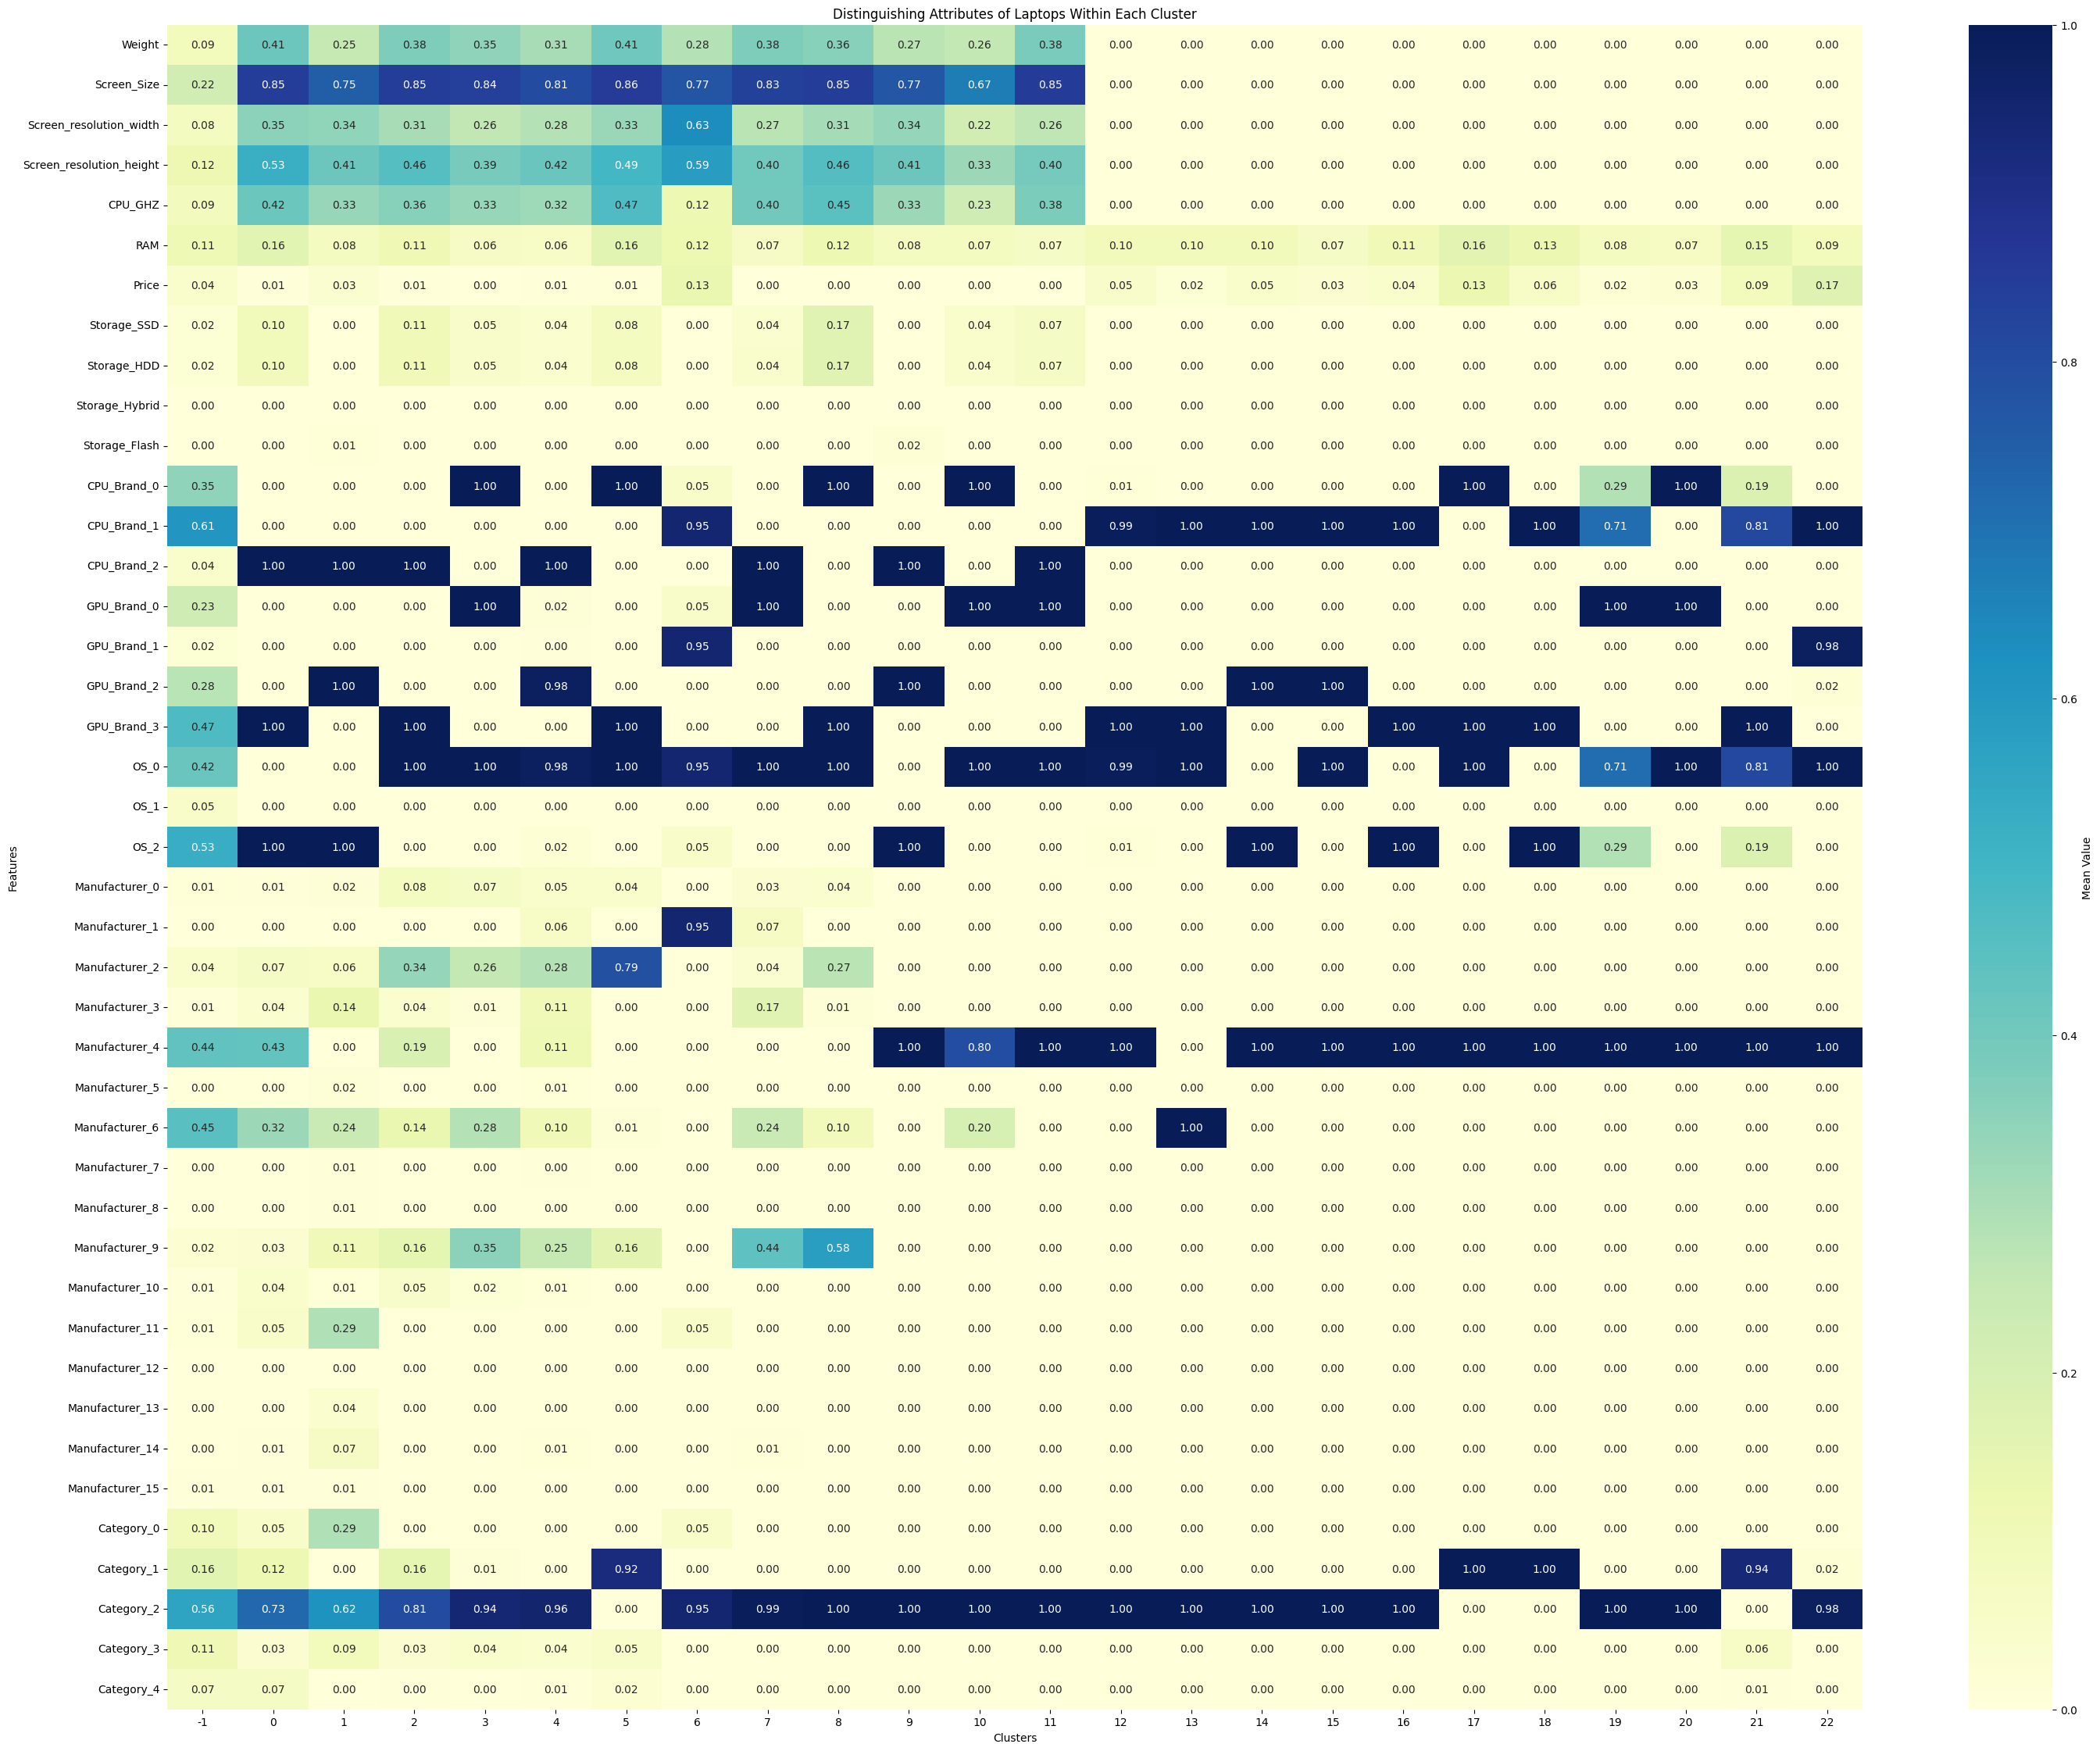

In [68]:
cluster_means_visual = cluster_means_pca_3d.drop(
    columns="Cluster_3D", errors="ignore"
).transpose()

plt.figure(figsize=(35, 28))
sns.heatmap(
    cluster_means_visual,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Mean Value"},
)
plt.title("Distinguishing Attributes of Laptops Within Each Cluster")
plt.ylabel("Features")
plt.xlabel("Clusters")
plt.show()

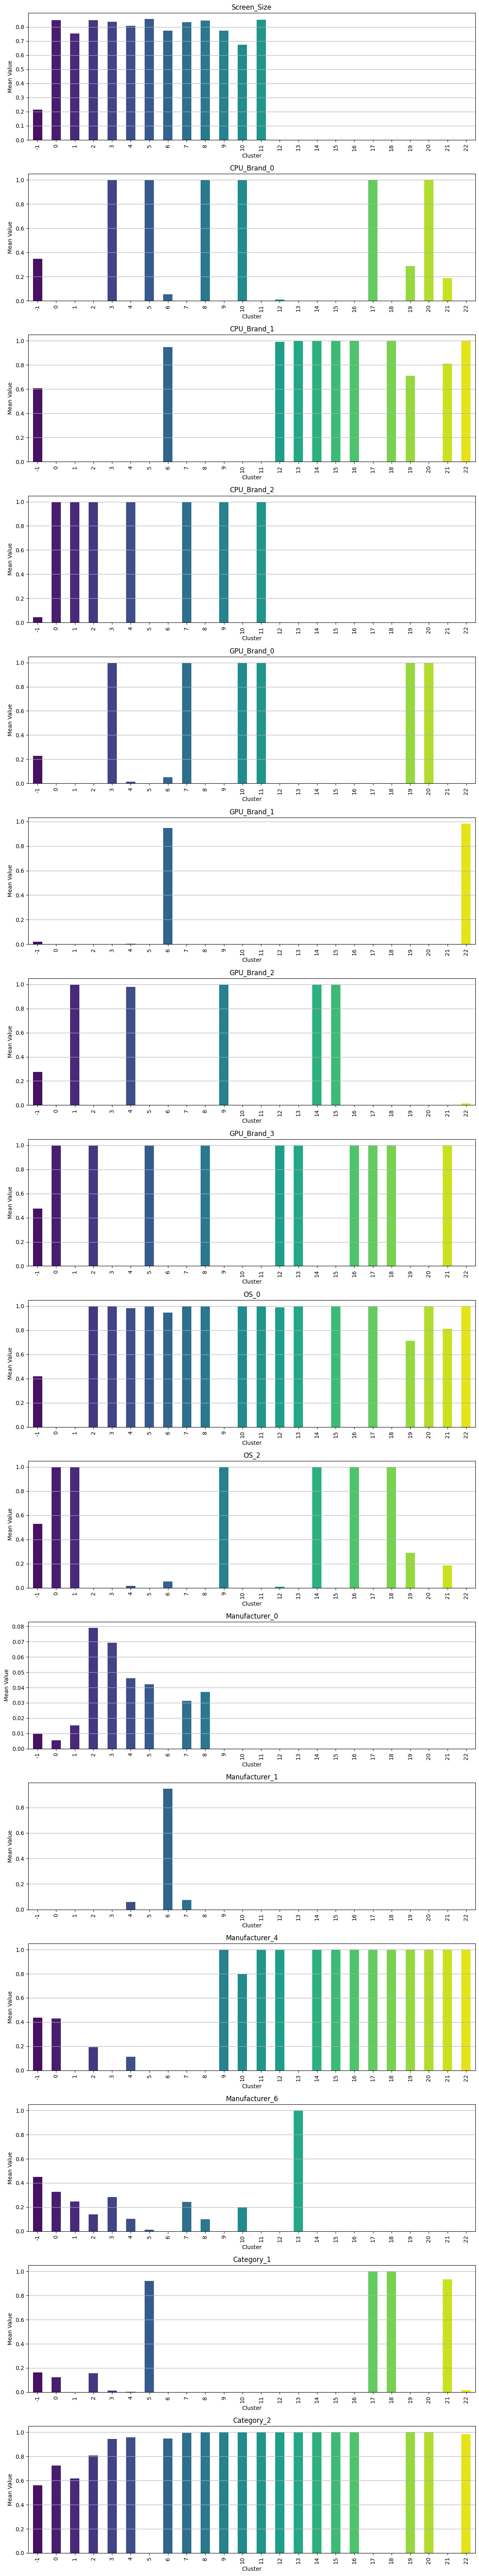

In [69]:
# List of features to plot
selected_features =[
    "Screen_Size",
    "CPU_Brand_0", "CPU_Brand_1", "CPU_Brand_2",
    "GPU_Brand_0", "GPU_Brand_1", "GPU_Brand_2", "GPU_Brand_3",
    "OS_0", "OS_2",
    "Manufacturer_0",
    "Manufacturer_1",
    "Manufacturer_4",
    "Manufacturer_6",
    "Category_1", "Category_2",
]

# Plotting the grouped bar charts for selected features
fig, axes = plt.subplots(
    nrows=len(selected_features), figsize=(12, 4 * len(selected_features))
)

for i, feature in enumerate(selected_features):
    cluster_means_visual.loc[feature].plot(
        kind="bar",
        ax=axes[i],
        color=sns.color_palette("viridis", n_colors=len(cluster_means_visual.columns)),
    )
    axes[i].set_title(feature)
    axes[i].set_ylabel("Mean Value")
    axes[i].set_xlabel("Cluster")
    axes[i].grid(axis="y")

plt.tight_layout()
plt.show()

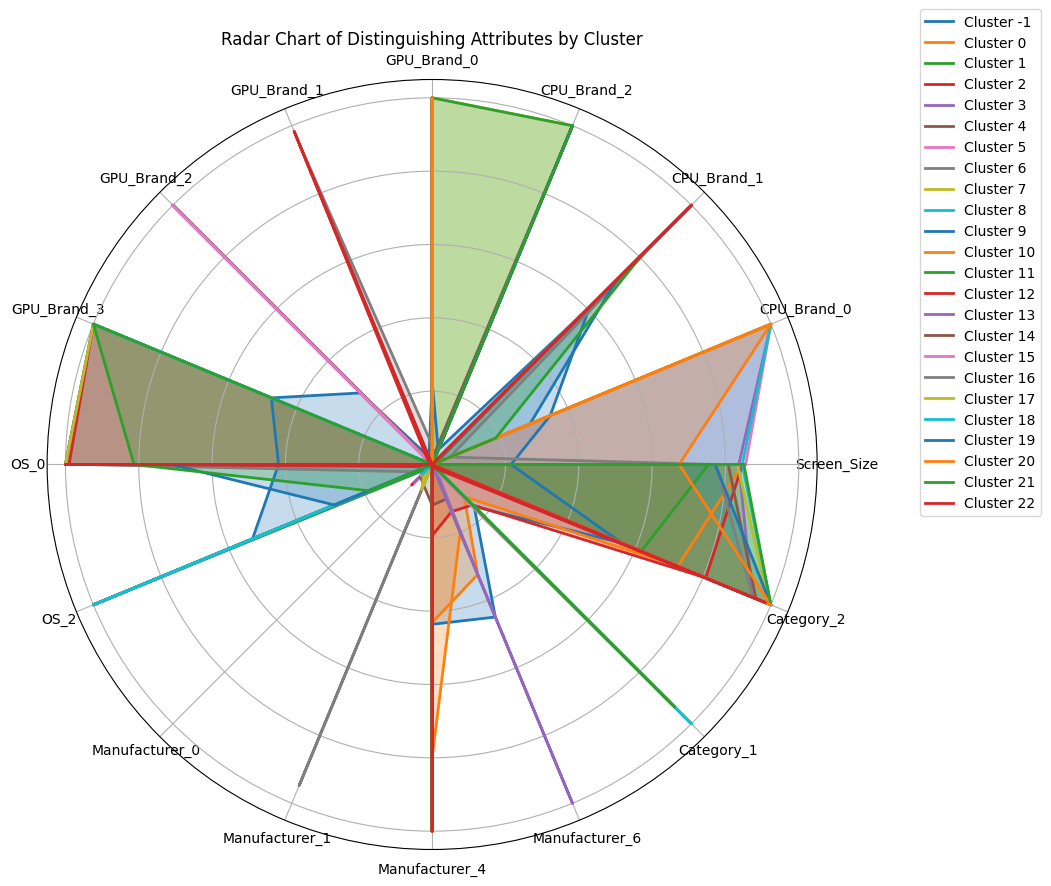

In [70]:
# Adjusting the feature names to match the provided dataframe
# adjusted_features = [
#     "Weight",
#     "Screen_Size",
#     "CPU_GHZ",
#     "RAM",
#     "Price",
#     "Storage_SSD",
#     "Storage_HDD",
# ]

adjusted_features = selected_features

num_vars = len(adjusted_features)

angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for cluster in cluster_means_visual.columns:
    values = cluster_means_visual[cluster][adjusted_features].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f"Cluster {cluster}")
    ax.fill(angles, values, alpha=0.25)

plt.title("Radar Chart of Distinguishing Attributes by Cluster")

ax.set_yticklabels([])
ax.yaxis.grid(True)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(adjusted_features)

ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

> To use our clustering, we nned to train a classifier on our clusters to be able to classify historical sales data

In [71]:
df_base_classified = df_base.copy()
df_base_classified["Class"] = df_3d["Cluster_3D"]
df_base_classified["Class"].value_counts()

Class
 2     4237
 4     1386
 0      557
 7      513
 12     511
 3      505
-1      413
 15     366
 1      196
 10     170
 5      166
 21     139
 9      112
 20     110
 14     103
 19      97
 13      90
 8       81
 16      81
 6       76
 22      62
 17      51
 18      50
 11      50
Name: count, dtype: int64

<Axes: title={'center': 'Class Distribution'}, xlabel='Class'>

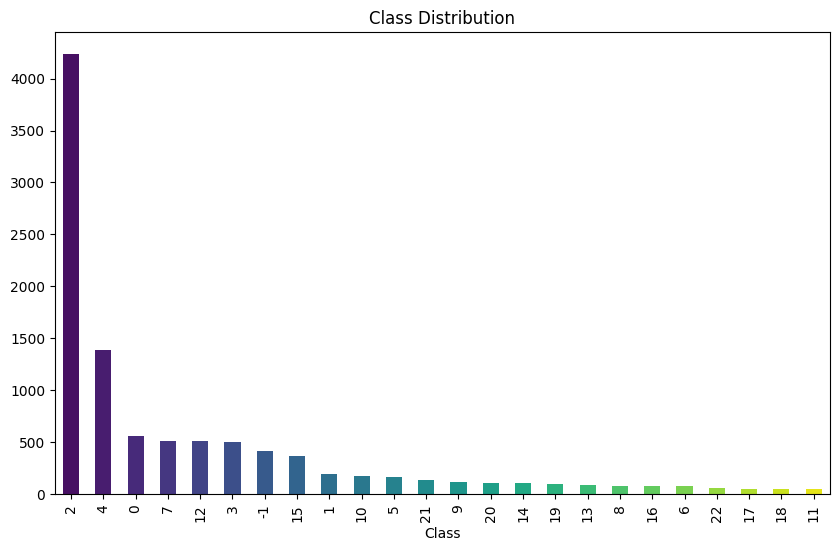

In [72]:
df_base_classified["Class"].value_counts().plot(
    kind="bar",
    figsize=(10, 6),
    color=sns.color_palette("viridis", n_colors=len(cluster_means_visual.columns)),
    title="Class Distribution",
)

> There seems we have heavy imbalance in our data.

### Train classifier based on clustering

In [73]:
X = df_base_classified.drop(columns=["Class"], errors="ignore")
y = df_base_classified["Class"]

In [74]:
# Handle imbalanced data with SMOTE oversampling and RandomUnderSampling

oversample = SMOTE()
undersample = RandomUnderSampler()

X, y = oversample.fit_resample(X, y)
X, y = undersample.fit_resample(X, y)

X.shape, y.shape

((101688, 42), (101688,))

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=274)

In [76]:
dtc = DecisionTreeClassifier(max_depth=7, random_state=274)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=274)

In [77]:
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

          -1       0.95      0.34      0.50       867
           0       1.00      1.00      1.00       857
           1       1.00      1.00      1.00       801
           2       1.00      1.00      1.00       834
           3       1.00      0.99      0.99       909
           4       1.00      1.00      1.00       881
           5       1.00      1.00      1.00       828
           6       1.00      1.00      1.00       886
           7       1.00      1.00      1.00       839
           8       1.00      1.00      1.00       838
           9       1.00      1.00      1.00       806
          10       1.00      1.00      1.00       883
          11       1.00      1.00      1.00       851
          12       0.00      0.00      0.00       914
          13       0.90      1.00      0.95       849
          14       0.84      1.00      0.91       815
          15       0.91      1.00      0.95       867
          16       0.43    

<Axes: >

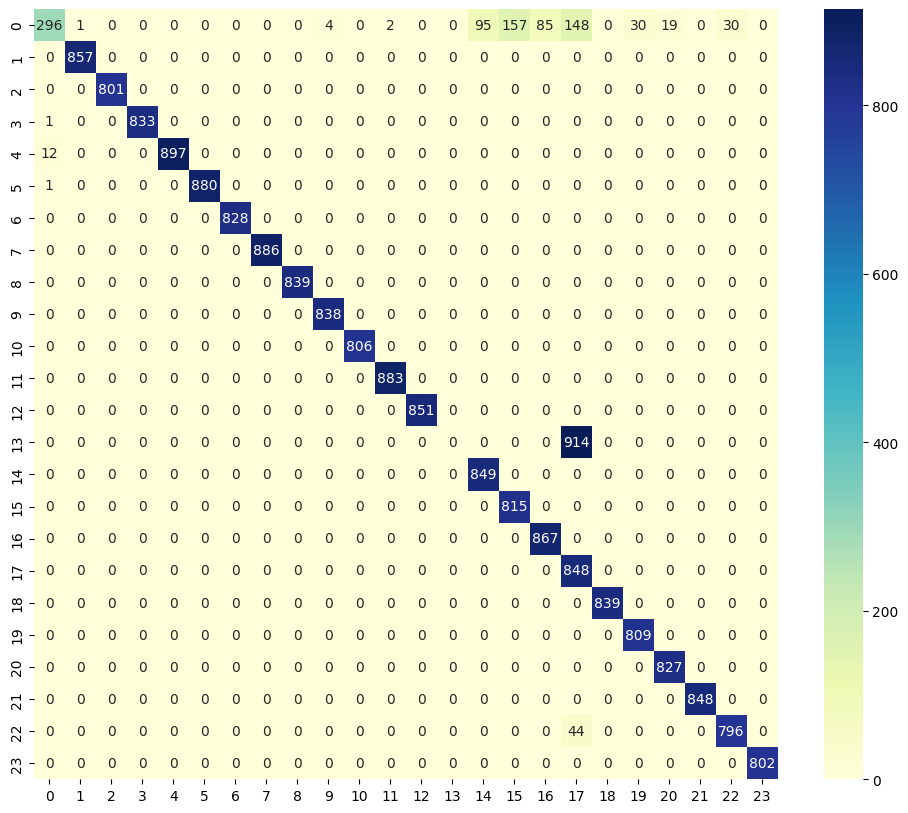

In [78]:
confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="YlGnBu")

## Historical sales analysis & classification based on clustering

In [79]:
df_depot.isna().sum()

Weight                          0
Screen_Size                     0
Screen_resolution_width         0
Screen_resolution_height        0
CPU_GHZ                     41527
RAM                             0
Price                           0
Storage_SSD                     0
Storage_HDD                     0
Storage_Hybrid                  0
Storage_Flash                   0
CPU_Brand_0                     0
CPU_Brand_1                     0
CPU_Brand_2                     0
GPU_Brand_0                     0
GPU_Brand_1                     0
GPU_Brand_2                     0
GPU_Brand_3                     0
OS_0                            0
OS_1                            0
OS_2                            0
Manufacturer_0                  0
Manufacturer_1                  0
Manufacturer_2                  0
Manufacturer_3                  0
Manufacturer_4                  0
Manufacturer_5                  0
Manufacturer_6                  0
Manufacturer_7                  0
Manufacturer_8

In [80]:
df_depot["CPU_GHZ"].value_counts(dropna=False)

CPU_GHZ
0.510204    289338
0.551020    137565
0.571429    108125
0.326531    100711
0.367347     86774
0.469388     85732
0.530612     54533
NaN          41527
0.489796     39071
0.224490     13396
0.244898     11818
0.408163      8457
0.591837      5027
0.448980      4700
0.734694      4689
0.183673      4055
0.265306      3315
0.428571      2657
0.293878      2652
0.387755      1631
0.306122      1581
0.204082       805
0.632653       721
0.653061       528
0.391837        91
Name: count, dtype: int64

In [81]:
df_depot["CPU_GHZ"].fillna(df_depot["CPU_GHZ"].median(), inplace=True)

In [82]:
df_depot["Class"] = dtc.predict(df_depot)
df_depot["Class"].value_counts()

Class
 1     465843
 0     287517
 4     145142
 2      43697
-1      36585
 8      24319
 7       2490
 9       2052
 22       835
 19       828
 10       191
Name: count, dtype: int64

In [83]:
df_depot["Quantity"] = pd.read_csv("sales_data_clean.csv", usecols=["Quantity"])
df_depot["Quantity"].value_counts()

Quantity
1    918837
2     75982
3     12927
4      1581
5       157
6        14
7         1
Name: count, dtype: int64

In [84]:
# Show sum of Quantity for each Class

df_depot.groupby("Class")["Quantity"].sum().sort_values(ascending=False)

Class
 1     515134
 0     318541
 4     160416
 2      48204
-1      40494
 8      26919
 7       2747
 9       2278
 22       928
 19       911
 10       210
Name: Quantity, dtype: int64

Now we have some classes that seem to be a potential sales points:

Classes:    <br>
 CPU Classes: {'AMD': 0, 'ETC': 1, 'Intel': 2}   <br>
 GPU Classes: {'AMD': 0, 'ETC': 1, 'Intel': 2, 'Nvidia': 3}  <br>
 OS Classes: {'ETC': 0, 'Linux': 1, 'Windows': 2}    <br>
 Manufacturer Classes: {'Acer': 0, 'Apple': 1, 'Asus': 2, 'Dell': 3, 'ETC': 4, 'Fujitsu': 5, 'HP': 6, 'Huawei': 7, 'LG': 8, 'Lenovo': 9, 'MSI': 10, 'Microsoft': 11, 'Razer': 12, 'Samsung': 13, 'Toshiba': 14, 'Xiaomi': 15}    <br>
 Category Classes: {'2 in 1 Convertible': 0, 'Gaming': 1, 'Notebook': 2, 'Ultrabook': 3, 'Workstation': 4}   <br>

### Class 1
1. category_2:        **Notebook**
2. manufacturer_6:    **HP**
3. os_2:              **Windows**
4. gpu_brand_2:       **Nvidia**
5. cpu_brand_2:       **Intel**
6. screen_size:       **75%**

### Class 0
1. category_2:      **Notebook**
2. manufacturer_3:  **Dell**
3. os_2:            **Windows**
4. gpu_brand_3:     **Nvidia**
5. cpu_brand_2:     **Intel**
6. screen_size:       **85%**

### Class 4
1. category_2:      **Notebook**
2. manufacturer_2:  **ASUS**
3. os_0:            **-**
4. gpu_brand_2:     **Intel**
5. cpu_brand_2:     **Intel**
6. screen_size:       **81%**

### Class 2
1. category_2:      **Notebook**
2. manufacturer_2:  **ASUS**
3. os_0:            **-**
4. gpu_brand_3:     **Nvidia**
5. cpu_brand_2:     **Intel**
6. screen_size:       **85%**

### Class 8
1. category_2:      **Notebook**
2. manufacturer_9:  **Lenovo**
3. os_0:            **-**
4. gpu_brand_3:     **Nvidia**
5. cpu_brand_0:     **AMD**
6. screen_size:       **85%**

### The Golden Formula!
- Category:     **Notebook**
- Manufacturer: **ASUS**
- OS:           **Windows**
- GPU Brand:    **Nvidia**
- CPU Brand:    **Intel**
- Screen Size:  **85% : 15"**